# Multilabel Classification

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/> 

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

# Setting Up

In [1]:
!nvidia-smi

Sat Jan 28 15:59:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.8/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/MasterCourse/Week 12 - Natural Language Processing/Lecture 51 - Multilabel Text Classification

/content/drive/MyDrive/MasterCourse/Week 12 - Natural Language Processing/Lecture 51 - Multilabel Text Classification


# Data

In [7]:
df = pd.read_csv("book_details.csv")
df.head()

,title,url,description,genres
0,To Kill a Mockingbird,https://www.goodreads.com/book/show/2657.To_Kill_a_Mockingbird,"The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. ""To Kill A Mockingbird"" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, ""To Kill A Mockingbird"" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copies in print and transla...","['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School']"
1,Harry Potter and the Philosopher’s Stone,https://www.goodreads.com/book/show/72193.Harry_Potter_and_the_Philosopher_s_Stone,"Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts School of Witchcraft and Wizardry, learns to play Quidditch and does battle in a deadly duel. The Reason ... HARRY POTTER IS A WIZARD!","['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics', 'Adventure', 'Audiobook', 'Science Fiction Fantasy']"
2,Pride and Prejudice,https://www.goodreads.com/book/show/1885.Pride_and_Prejudice,"Alternate cover edition of ISBN 9780679783268Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular novels in the English language. Jane Austen called this brilliant work ""her own darling child"" and its vivacious heroine, Elizabeth Bennet, ""as delightful a creature as ever appeared in print."" The romantic clash between the opinionated Elizabeth and her proud beau, Mr. Darcy, is a splendid performance of civilized sparring. And Jane Austen's radiant wit sparkles as her characters dance a delicate quadrille of flirtation and intrigue, making this book t...","['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook', 'Novels', 'Historical Romance', 'Adult']"
3,The Diary of a Young Girl,https://www.goodreads.com/book/show/48855.The_Diary_of_a_Young_Girl,"Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable diary has become a world classic—a powerful reminder of the horrors of war and an eloquent testament to the human spirit.In 1942, with the Nazis occupying Holland, a thirteen-year-old Jewish girl and her family fled their home in Amsterdam and went into hiding. For the next two years, until their whereabouts were betrayed to the Gestapo, the Franks and another family lived cloistered in the “Secret Annexe” of an old office building. Cut off from the outside world, they faced hunger, boredom, the ...","['Classics', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']"
4,Animal Farm,https://www.goodreads.com/book/show/170448.Animal_Farm,"Librarian's note: There is an Alternate Cover Edition for this edition of this book here.A farm is taken over by its overworked, mistreated animals. With flaming idealism and stirring slogans, they set out to create a paradise of progress, justice, and equality. Thus the stage is set for one of the most telling satiric fables ever penned –a razor-edged fairy tale for grown-ups that records the evolution from revolution against tyranny to a totalitarianism just as terrible.When was first published, Stalinist Russia was seen as its target. Today it is devastatingly clear that wherever and wh...","['Classics', 'Fiction', 'Dystopia', 'Fantasy', 'Politics', 'Literature', 'School', 'Science Fiction', 'Novels', 'Read For School']"


In [8]:
df.shape

(6313, 4)

In [9]:
df = df.dropna().reset_index(drop=True)
df.shape

(6274, 4)

In [10]:
genres_list = df.genres.to_list()
genre_count = {}
for genres in genres_list:
  genre_list = eval(genres)
  for genre in genre_list:
    if genre in genre_count.keys():
      genre_count[genre] += 1
    else:
      genre_count[genre] = 1
print(f"Number of Genres: {len(genre_count)}")
print(genre_count)

Number of Genres: 640
{'Classics': 1918, 'Fiction': 4315, 'Historical Fiction': 1262, 'School': 423, 'Literature': 1363, 'Young Adult': 1263, 'Historical': 1008, 'Read For School': 109, 'Novels': 1657, 'High School': 77, 'Fantasy': 1664, 'Magic': 387, 'Childrens': 572, 'Middle Grade': 406, 'Adventure': 931, 'Audiobook': 1915, 'Science Fiction Fantasy': 511, 'Romance': 1185, 'Historical Romance': 76, 'Adult': 1278, 'Nonfiction': 1527, 'History': 630, 'Biography': 554, 'Memoir': 476, 'Holocaust': 78, 'Dystopia': 292, 'Politics': 353, 'Science Fiction': 710, 'France': 154, 'Philosophy': 698, 'French Literature': 76, 'American': 369, 'Coming Of Age': 162, 'Epic Fantasy': 113, 'High Fantasy': 192, 'War': 340, 'World War II': 155, 'Books About Books': 49, 'Gothic': 86, '19th Century': 158, 'Christian': 187, 'Christian Fiction': 71, 'Plays': 152, 'Drama': 468, 'Poetry': 232, 'Contemporary': 1306, 'Picture Books': 120, 'Juvenile': 176, 'Short Stories': 282, 'Kids': 61, 'Animals': 159, 'Chapter

In [15]:
threshold = int(len(df) * 0.01)
rare_genres = [key for key, value in genre_count.items() if value < threshold]
len(rare_genres), rare_genres[:5]

(499, ['Books About Books', 'Kids', 'Chapter Books', 'Food', 'Civil War'])

In [16]:
genres_list = df.genres.to_list()
revised_genre_list = []
indices_to_drop = []

for idx, genres in enumerate(genres_list):
  genre_list = eval(genres)
  revised_genres = []

  for genre in genre_list:
    if genre not in rare_genres:
      revised_genres.append(genre)

  if len(revised_genres) == 0:
    indices_to_drop.append(idx)
  else:
    revised_genre_list.append(revised_genres)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(6104, 4)

In [17]:
df['revised_genres'] = revised_genre_list

In [20]:
df.tail()

,title,url,description,genres,revised_genres
6099,The Blank Slate: The Modern Denial of Human Nature,https://www.goodreads.com/book/show/5752.The_Blank_Slate,"In The Blank Slate, Steven Pinker explores the idea of human nature and its moral, emotional, and political colorings. He shows how many intellectuals have denied the existence of human nature by embracing three linked dogmas: the Blank Slate (the mind has no innate traits), the Noble Savage (people are born good and corrupted by society), and the Ghost in the Machine (each of us has a soul that makes choices free from biology). Each dogma carries a moral burden, so their defenders have engaged in desperate tactics to discredit the scientists who are now challenging them.Pinker injects cal...","['Psychology', 'Science', 'Nonfiction', 'Philosophy', 'Sociology', 'Biology', 'Politics', 'Evolution', 'Anthropology', 'Neuroscience']","[Psychology, Science, Nonfiction, Philosophy, Sociology, Politics]"
6100,La leyenda del Rey Errante,https://www.goodreads.com/book/show/1146745.La_leyenda_del_Rey_Errante,"Cuenta la historia de Walid, un príncipe árabe que desea ser un gran poeta. Para ello, pide permiso a su padre para asistir al prestigioso certamen poético de Ukaz. Pero el rey le pone como condición que primero ha de demostrar que es el mejor poeta de su reino. Walid organiza su propio certamen de poesía pero, durante tres años consecutivos, le vence Hammad, un humilde tejedor de alfombras, pobre y analfabeto.Envidioso, Walid lo nombra historiador real y le impone una serie de tareas imposibles, como ordenar el enorme y caótico archivo de palacio o tejer una alfombra que contenga toda la ...","['Fantasy', 'Historical Fiction', 'Fiction', 'Young Adult', 'Adventure', 'Historical', 'Middle Grade', 'Spanish Literature', 'Childrens', 'Teen']","[Fantasy, Historical Fiction, Fiction, Young Adult, Adventure, Historical, Middle Grade, Childrens, Teen]"
6101,"This Way for the Gas, Ladies and Gentlemen",https://www.goodreads.com/book/show/228244.This_Way_for_the_Gas_Ladies_and_Gentlemen,"Tadeusz Borowski’s concentration camp stories were based on his own experiences surviving Auschwitz and Dachau. In spare, brutal prose he describes a world where where the will to survive overrides compassion and prisoners eat, work and sleep a few yards from where others are murdered; where the difference between human beings is reduced to a second bowl of soup, an extra blanket or the luxury of a pair of shoes with thick soles; and where the line between normality and abnormality vanishes. Published in Poland after the Second World War, these stories constitute a masterwork of world lite...","['History', 'Short Stories', 'Holocaust', 'Nonfiction', 'War', 'Polish Literature', 'Classics']","[History, Short Stories, Holocaust, Nonfiction, War, Classics]"
6102,The Warded Man,https://www.goodreads.com/book/show/3428935-the-warded-man,"As darkness falls after sunset, the corelings rise—demons who possess supernatural powers and burn with a consuming hatred of humanity. For hundreds of years the demons have terrorized the night, slowly culling the human herd that shelters behind magical wards—symbols of power whose origins are lost in myth and whose protection is terrifyingly fragile. It was not always this way. Once, men and women battled the corelings on equal terms, but those days are gone. Night by night the demons grow stronger, while human numbers dwindle under their relentless assault. Now, with hope for the future...","['Fantasy', 'Fiction', 'Epic Fantasy', 'High Fantasy', 'Magic', 'Demons', 'Adventure', 'Dark Fantasy', 'Science Fiction Fantasy', 'Audiobook']","[Fantasy, Fiction, Epic Fantasy, High Fantasy, Magic, Adventure, Science Fiction Fantasy, Audiobook]"
6103,Raising Steam,https://www.goodreads.com/book/show/18361450-raising-steam,"Change is in the air for Moist von Lipwig, swindler, con-man, and (naturally) head of the Royal Bank and Post Office.A steaming, clanging new invention – a steam loc

In [18]:
revised_genres_list = df.revised_genres.to_list()
revised_genre_count = {}
for genres in revised_genres_list:
  genre_list = genres
  for genre in genre_list:
    if genre in revised_genre_count.keys():
      revised_genre_count[genre] += 1
    else:
      revised_genre_count[genre] = 1
print(f"Number of Genres: {len(revised_genre_count)}")
print(revised_genre_count)

Number of Genres: 141
{'Classics': 1918, 'Fiction': 4315, 'Historical Fiction': 1262, 'School': 423, 'Literature': 1363, 'Young Adult': 1263, 'Historical': 1008, 'Read For School': 109, 'Novels': 1657, 'High School': 77, 'Fantasy': 1664, 'Magic': 387, 'Childrens': 572, 'Middle Grade': 406, 'Adventure': 931, 'Audiobook': 1915, 'Science Fiction Fantasy': 511, 'Romance': 1185, 'Historical Romance': 76, 'Adult': 1278, 'Nonfiction': 1527, 'History': 630, 'Biography': 554, 'Memoir': 476, 'Holocaust': 78, 'Dystopia': 292, 'Politics': 353, 'Science Fiction': 710, 'France': 154, 'Philosophy': 698, 'French Literature': 76, 'American': 369, 'Coming Of Age': 162, 'Epic Fantasy': 113, 'High Fantasy': 192, 'War': 340, 'World War II': 155, 'Gothic': 86, '19th Century': 158, 'Christian': 187, 'Christian Fiction': 71, 'Plays': 152, 'Drama': 468, 'Poetry': 232, 'Contemporary': 1306, 'Picture Books': 120, 'Juvenile': 176, 'Short Stories': 282, 'Animals': 159, 'Teen': 266, 'Post Apocalyptic': 126, 'Humor'

In [21]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [25]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df.revised_genres.to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)
  for genre in revised_genres:
    genre_type_index = encode_genre_types[genre] 
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [26]:
df['genre_cat_list'] = categorical_genre_list
df.head()

,title,url,description,genres,revised_genres,genre_cat_list
0,To Kill a Mockingbird,https://www.goodreads.com/book/show/2657.To_Kill_a_Mockingbird,"The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. ""To Kill A Mockingbird"" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, ""To Kill A Mockingbird"" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copies in print and transla...","['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School']","[Classics, Fiction, Historical Fiction, School, Literature, Young Adult, Historical, Read For School, Novels, High School]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Harry Potter and the Philosopher’s Stone,https://www.goodreads.com/book/show/72193.Harry_Potter_and_the_Philosopher_s_Stone,"Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts School of Witchcraft and Wizardry, learns to play Quidditch and does battle in a deadly duel. The Reason ... HARRY POTTER IS A WIZARD!","['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics', 'Adventure', 'Audiobook', 'Science Fiction Fantasy']","[Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Classics, Adventure, Audiobook, Science Fiction Fantasy]","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Pride and Prejudice,https://www.goodreads.com/book/show/1885.Pride_and_Prejudice,"Alternate cover edition of ISBN 9780679783268Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular novels in the English language. Jane Austen called this brilliant work ""her own darling child"" and its vivacious heroine, Elizabeth Bennet, ""as delightful a creature as ever appeared in print."" The romantic clash between the opinionated Elizabeth and her proud beau, Mr. Darcy, is a splendid performance of civilized sparring. And Jane Austen's radiant wit sparkles as her characters dance a delicate quadrille of flirtation and intrigue, making this book t...","['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook', 'Novels', 'Historical Romance', 'Adult']","[Classics, Fiction, Romance, Historical Fiction, Literature, Historical, Audiobook, Novels, Historical Romance, Adult]","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,The Diary of a Young Girl,https://www.goodreads.com/book/show/48855.The_Diary_of_a_Young_Girl,"Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable diary has become a world classic—a powerful reminder of the horrors of war and an eloquent testament to the human spirit.In 1942, with the Nazis occupying Holland, a thirteen-year-old Jewish girl and her family fled their home in Amsterdam and went into hiding. For the next two years, un

# Dataloaders and Modeling

In [27]:
labels = list(encode_genre_types.keys())

In [28]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [31]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [32]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dataloaders/dls-multilabel-book-classifier.pkl")

In [ ]:
# dls = torch.load("dataloaders/dls-multilabel-book-classifier.pkl")

In [33]:
dls.vocab

['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School', 'Fantasy', 'Magic', 'Childrens', 'Middle Grade', 'Adventure', 'Audiobook', 'Science Fiction Fantasy', 'Romance', 'Historical Romance', 'Adult', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Holocaust', 'Dystopia', 'Politics', 'Science Fiction', 'France', 'Philosophy', 'French Literature', 'American', 'Coming Of Age', 'Epic Fantasy', 'High Fantasy', 'War', 'World War II', 'Gothic', '19th Century', 'Christian', 'Christian Fiction', 'Plays', 'Drama', 'Poetry', 'Contemporary', 'Picture Books', 'Juvenile', 'Short Stories', 'Animals', 'Teen', 'Post Apocalyptic', 'Humor', 'Horror', 'LGBT', 'Classic Literature', 'Religion', 'Christianity', 'Reference', 'Spirituality', 'Theology', 'Comedy', 'Theatre', 'Essays', 'Fairy Tales', 'Mythology', 'Self Help', 'Inspirational', 'Russia', 'Adult Fiction', 'Book Club', 'Chick Lit', 'Japan', 'Asia', 'Realistic Fic

In [34]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,في مجال المسرح و الشعر ، و فى المجال الأدبي عموما معروف.. ان هناك ادب بيتم تطويع المواضيع و الافكار له..، و ادب بيتم تطويعه و استخدامه لعرض الافكار و المواضيع من خلالهفي المسرح مثلا عندنا تجارب لتوفيق الحكيم و لدكتور مصطفى محمود من مسرحيات هي فنيا قد تكون غير صالحة باعتراف اصحابها ذاتهم.. لكنها على مستوى عرض الموضوع و الفكرة ناجحة طبعا..،كذلك فى الشعر.. هناك اشعار بيتم تطويع المواضيع و الأفكار لها.. و هناك اشعار بيتم تطويعها و استخدامها لعرض الافكار و المواضيع و الأحداث.. الشئ اللى بيجعل الجانب الفني فيها,"[Literature, Nonfiction, Philosophy, Poetry, Spirituality, Inspirational]"
1,ﻳﺼﻒ ﻟﻨﺎ ﻧﺠﻴﺐ ﻣﺤﻔﻮﻅ ﺳﻌﻲ ﺍﻟﻨﻔﺲ ﺍﻟﺒﺸﺮﻳﺔ ﺍﻟﺪﺍﺋﻢ ﺍﻟﻰ ﺍﻟﺨﻼﺹ ﻭﺗﻤﺮﺩﻫﺎ ﻋﻠﻰ ﻧﻔﺴﻬﺎ ﺍﻟﺘﻲ ﺍﺭﺗﻀﺖ ﺑﺎﻟﻮﺍﻗﻊ ﺍﻟﻤﺮﻳﺮ، ﻓﺘﺤﺜﻬﺎ ﺩﺍﺋﻤﺎ ﺍﻟﻰ ﺍﻟﺨﻼﺹ، ﻭﺍﻟﺨﺮﻭﺝ ﻣﻦ ﻧﻔﻖ ﺍﻟﻨﻔﺲ ﺍﻟﻤﻈﻠﻢ، ﻭﻟﻜﻨﻬﺎ ﺗﺼﻄﺪﻡ ﺩﺍﺋﻤﺎ ﺑﺤﺐ ﺍﻟﺪﻧﻴﺎ ﻭﺍﻏﻮﺍﺋﺎﺗﻬﺎ ﺍﻟﻼﻣﺤﺪﻭﺩﺓ ﻭ�,"[Classics, Fiction, Historical Fiction, Literature, Novels, Literary Fiction, Africa, Nobel Prize]"
2,"Rokovye jajca. Zapiski junogo vracha. Роковые яйца. Записки юного врача.Михаил Афанасьевич Булгаков (1891–1940) – великий русский писатель и драматург, автор повестей, рассказов, фельетонов, пьес, инсценировок, киносценариев и оперных либретто, по профессии врач. Одним из самых известных произведений М.Булгакова является роман «Мастер и Маргарита», который английская газета «The Times» назвала одним из литературных шедевров 20 века.В сборник произведений М.Булгакова от Animedia Company входит повесть «Роко","[Fiction, Russia]"
3,"The Art of Startup Fundraising takes a fresh look at raising money for startups, with a focus on the changing face of startup finance. New regulations are making the old go-to advice less relevant, as startup money is increasingly moving online. These new waters are all but uncharted—and founders need an accessible guide. This book helps you navigate the online world of startup fundraising with easy-to-follow explanations and expert perspective on the new digital world of finance. You'll find tips and tric","[Nonfiction, Self Help, Economics, Business, Personal Development, Productivity]"


In [35]:
doc(accuracy_multi)

In [36]:
model = BaseModelWrapper(hf_model)
 
acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls, 
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# Stage - 0

In [37]:
learner.freeze()

SuggestedLRs(slide=0.0006918309954926372, valley=0.00013182566908653826)

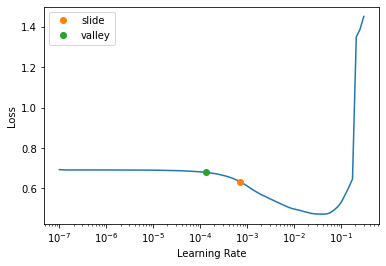

In [38]:
learner.lr_find(suggest_funcs=[slide, valley])

In [39]:
learner.fit_one_cycle(2,4.75e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.193462,0.156792,0.925729,00:36
1,0.140244,0.134715,0.940298,00:34


In [40]:
learner.save("book-classifier-stage-0")

Path('models/book-classifier-stage-0.pth')

In [41]:
learner.export("models/book-classifier-stage-0.pkl")

# Stage - 1

In [ ]:
# learner.load("book-classifier-stage-0")

In [42]:
learner.unfreeze()

SuggestedLRs(slide=0.005248074419796467, valley=1.737800812406931e-05)

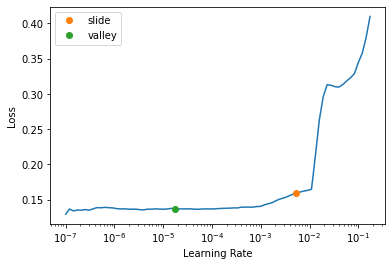

In [43]:
learner.lr_find(suggest_funcs=[slide, valley])

In [44]:
learner.fit_one_cycle(3,slice(4.75e-3, 2.25e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.145752,0.139841,0.935333,00:44
1,0.124982,0.126526,0.942088,00:44
2,0.111108,0.121283,0.945681,00:44


In [45]:
learner.save("book-classifier-stage-1")

Path('models/book-classifier-stage-1.pth')

In [46]:
learner.export("models/book-classifier-stage-1.pkl")